# Monitoring VQE convergence

Variational algorithms in Qiskit, like [VQE](https://qiskit.org/documentation/stubs/qiskit.algorithms.VQE.html) and [QAOA](https://qiskit.org/documentation/stubs/qiskit.algorithms.QAOA.html), provide the option for a user to give a callback method that can be used to monitor optimization progress as the algorithm runs and converges to the minimum. The callback is invoked for each functional evaluation by the optimizer and provides the current optimizer value, evaluation count, current optimizer parameters etc. Note that, depending on the specific optimizer this may not be each iteration (step) of the optimizer, so for example if the optimizer is calling the cost function to compute a finite difference based gradient this will be visible via the callback.

This notebook demonstrates using Qiskit's VQE algorithm to plot graphs of the convergence path to ground state energy with a selected set of optimizers.

In [1]:
import numpy as np
import pylab

from qiskit import Aer
from qiskit.opflow import X, Z, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal

First we create a qubit operator for VQE. Here we will use the same operator as used in the algorithms introduction, which was originally computed by Qiskit Nature for an H2 molecule.

In [3]:
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

We will show the callback usage below over a set of optimizers for comparison. The minimum energy of the H2 Hamiltonian can be found quite easily so we are able to set maxiters to a small value

In [4]:
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
  
    vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
              quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
print('\rOptimization complete      ');

Optimization complete      


In [7]:
values

[-1.073925543269824,
 -1.073925548504951,
 -1.07392553895963,
 -1.0739255440498714,
 -1.0739255488755322,
 -1.0739255487127768,
 -1.0739255360498867,
 -1.073925545845488,
 -1.0739255376942343,
 -1.4369893406092886,
 -1.4369893423156896,
 -1.436989348008884,
 -1.4369893403359044,
 -1.4369893365887543,
 -1.4369893420433912,
 -1.4369893451507305,
 -1.4369893466540327,
 -1.4369893432729821,
 -1.7459669444357455,
 -1.745966945417978,
 -1.7459669491260468,
 -1.7459669435441416,
 -1.7459669415861976,
 -1.7459669455554232,
 -1.745966947773206,
 -1.745966947632886,
 -1.7459669456714684,
 -1.753992476954627,
 -1.8498673671094106,
 -1.8498673664304819,
 -1.849867367631353,
 -1.8498673662736256,
 -1.8498673659109561,
 -1.8498673664451206,
 -1.849867368083271,
 -1.8498673665791832,
 -1.8498673680429487,
 -1.851576716667484,
 -1.8567962776485094,
 -1.8567962778474512,
 -1.8567962775400053,
 -1.8567962774156337,
 -1.8567962775254894,
 -1.8567962778130283,
 -1.8567962774822089,
 -1.8567962777094353,
 

Now from the callback data we stored we can plot the energy value at each objective function call each optimizer makes. An optimizer using a finite difference method for computing gradient has that characteristic step like plot where for a number of evaluations it is computing the value for close by points to establish a gradient (the close by points having very similar values whose difference cannot be seen on the scale of the graph here).

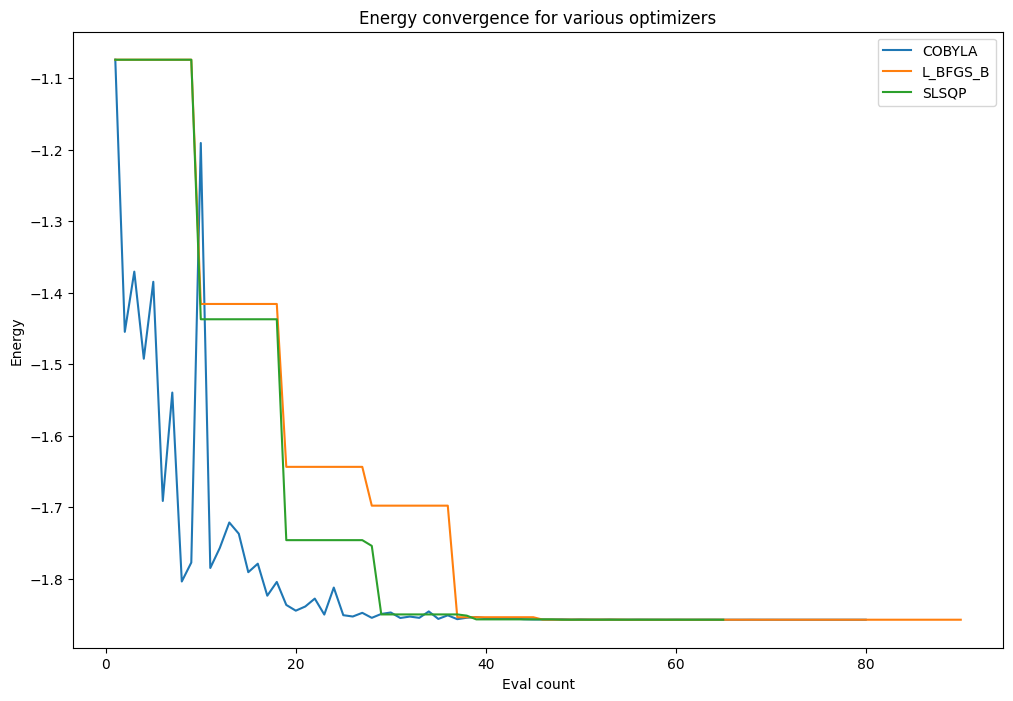

In [8]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

Finally since the above problem is still easily tractable classically we can use NumPyMinimumEigensolver to compute a reference value for the solution. We can now plot the difference from the resultant exact solution as the energy converges with VQE towards the minimum value which should be that exact classical solution.

In [5]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.85728


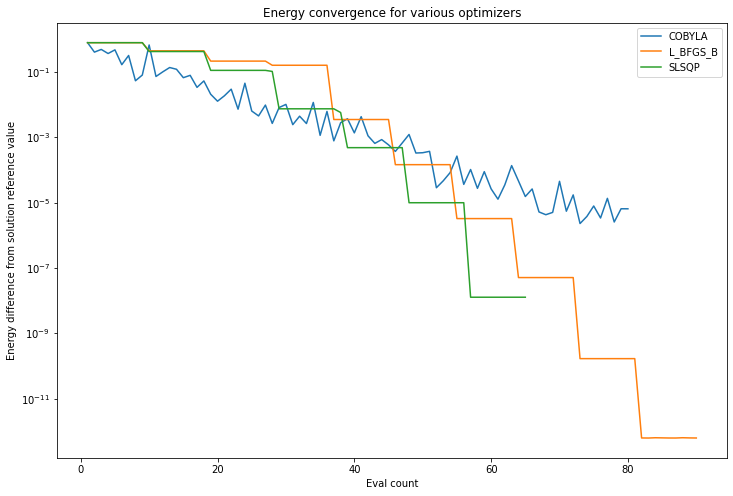

In [6]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], abs(ref_value - converge_vals[i]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right');

## Using Gradient framework

Qiskit now has a Gradient framework as part of the Opflow capability. With the gradient computed for the optimizer we now see just the optimization steps themselves.

In [7]:
from qiskit.opflow.gradients import Gradient

algorithm_globals.random_seed = 50
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

optimizer = SLSQP(maxiter=60)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
          gradient=Gradient(grad_method='fin_diff'),
          quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'Value using Gradient: {result.eigenvalue.real:.5f}')

Value using Gradient: -1.85728


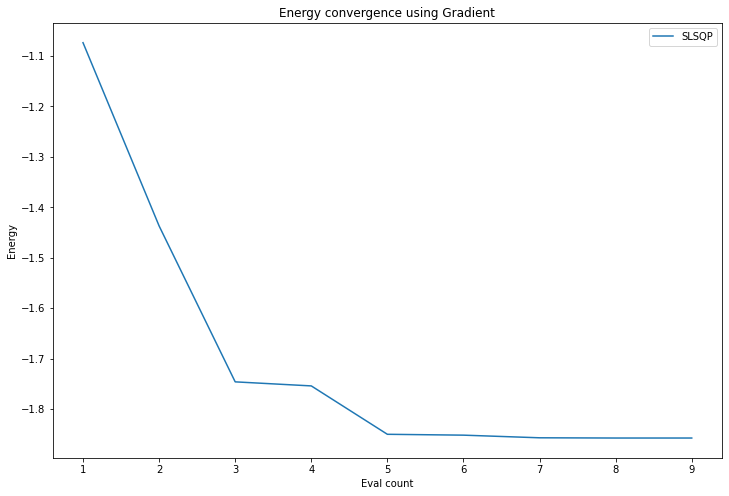

In [8]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(counts, values, label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence using Gradient')
pylab.legend(loc='upper right');

## Monitoring via the logging

Much of the code is instrumented with [Python logging](https://docs.python.org/3/library/logging.html) statements. The logging is configurable to adjust level of logging etc. Here we set the logging level to `INFO`

In [9]:
import logging
logging.basicConfig(level=logging.INFO)
logging.getLogger('qiskit.algorithms.minimum_eigen_solvers.vqe').setLevel(logging.INFO)

and at INFO level logging VQE will include information on the evaluations, as below.

INFO:qiskit.algorithms.minimum_eigen_solvers.vqe:Energy evaluation returned [-1.07392554] - 116.41884 (ms), eval count: 1
INFO:qiskit.algorithms.minimum_eigen_solvers.vqe:Energy evaluation returned [-1.43698938] - 4.05884 (ms), eval count: 2
INFO:qiskit.algorithms.minimum_eigen_solvers.vqe:Energy evaluation returned [-1.74596698] - 7.40194 (ms), eval count: 3
INFO:qiskit.algorithms.minimum_eigen_solvers.vqe:Energy evaluation returned [-1.75399268] - 6.61016 (ms), eval count: 4

In [10]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright